In [54]:
from mbnpy import brc, cpm, variable, inference, branch
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import networkx as nx


# Load data

In [55]:
df_schools = pd.read_excel(r"data/Schools_Buildings_Fragility_Data_selected.xlsx")
df_schools = df_schools[df_schools['Function']=='Classroom'] # select only classrooms

In [56]:
print(df_schools)

                           School Build code   Function  No. of Classrooms  \
0        East City Central School      EAS01  Classroom                 24   
1        East City Central School      EAS02  Classroom                 22   
3        East City Central School      EAS04  Classroom                 16   
4        East City Central School      EAS05  Classroom                 10   
5        East City Central School      EAS06  Classroom                  8   
7        East City Central School      EAS10  Classroom                  9   
8        East City Central School      EAS11  Classroom                  4   
9        East City Central School      EAS12  Classroom                  3   
10       East City Central School      EAS13  Classroom                  2   
11       East City Central School      EAS14  Classroom                  2   
12       East City Central School      EAS15  Classroom                  2   
13  Consolacion Elementary School      CON02  Classroom         

In [57]:
school_names = ['East City Central School', 'Consolacion Elementary School']

print(f"Building codes (=component names):")
build_names = {}
for sc in school_names:
    df_school1 = df_schools[df_schools['School'] == sc]
    build_names[sc] = df_school1['Build code'].tolist()
    print(f"{sc}: {build_names[sc]}")

Building codes (=component names):
East City Central School: ['EAS01', 'EAS02', 'EAS04', 'EAS05', 'EAS06', 'EAS10', 'EAS11', 'EAS12', 'EAS13', 'EAS14', 'EAS15']
Consolacion Elementary School: ['CON02', 'CON03', 'CON04', 'CON05', 'CON07', 'CON08', 'CON09', 'CON10', 'CON12']


In [58]:
pga_g = 0.4 # 2500-year return period

df_schools['pf'] = df_schools.apply(lambda row: norm.cdf(math.log(pga_g), math.log(row['mean']), row['std']), axis=1)
print(df_schools[['Build code', 'mean', 'std', 'pf']])

   Build code      mean       std            pf
0       EAS01  0.764607  0.276836  9.632398e-03
1       EAS02  1.152667  0.302997  2.388121e-04
3       EAS04  1.152667  0.302997  2.388121e-04
4       EAS05  1.383200  0.302997  2.113317e-05
5       EAS06  1.067485  0.275982  1.877448e-04
7       EAS10  0.849689  0.303634  6.545247e-03
8       EAS11  1.383200  0.302997  2.113317e-05
9       EAS12  1.067485  0.275982  1.877448e-04
10      EAS13  1.560711  0.269233  2.132807e-07
11      EAS14  0.564000  0.360000  1.699366e-01
12      EAS15  1.067485  0.275982  1.877448e-04
13      CON02  1.152667  0.302997  2.388121e-04
14      CON03  1.300592  0.269233  5.947142e-06
15      CON04  1.300592  0.269233  5.947142e-06
16      CON05  1.067485  0.275982  1.877448e-04
18      CON07  0.521758  0.396797  2.515215e-01
19      CON08  1.699378  0.303634  9.483184e-07
20      CON09  1.300592  0.269233  5.947142e-06
21      CON10  0.849689  0.303634  6.545247e-03
23      CON12  1.383200  0.302997  2.113

# Build MBN

In [59]:
varis = {}
cpms = {}
probs = {} # for later use in BRC algorithm
for sc in school_names:
    df_school1 = df_schools[df_schools['School'] == sc]

    varis[sc] = {}
    cpms[sc] = {}
    probs[sc] = {}
    for b in build_names[sc]:
        n_class = df_school1[df_school1['Build code'] == b]['No. of Classrooms'].values[0]
        n_class = int(n_class)

        varis[sc][b] = variable.Variable(name = b, values = [0, n_class]) # State 0 stands for 0 capacity, 1 for full capacity

        pf_b = df_school1[df_school1['Build code'] == b]['pf'].values[0]
        pf_b = float(pf_b)
        probs[sc][b] = {0: pf_b, 1: 1.0-pf_b}
        cpms[sc][b] = cpm.Cpm(variables = [varis[sc][b]],
                              no_child = 1,
                              C = np.array([[0], [1]]),
                              p = np.array([pf_b, 1.0-pf_b]))


Add bridge failures.

In [60]:
varis['bridge'] = {}
varis['bridge']['b1'] = variable.Variable(name = 'b1', values = ['f', 's']) # 0 for failure and 1 for success
varis['bridge']['b2'] = variable.Variable(name = 'b2', values = ['f', 's']) # 0 for failure and 1 for success

cpms['bridge'] = {}
cpms['bridge']['b1'] = cpm.Cpm(variables = [varis['bridge']['b1']],
                               no_child = 1,
                               C = np.array([[0], [1]]),
                               p = np.array([0.07302, 1.0-0.07302])) # failure probability of bridge 1

cpms['bridge']['b2'] = cpm.Cpm(variables = [varis['bridge']['b2']],
                               no_child = 1,
                               C = np.array([[0], [1]]),
                               p = np.array([0.1307, 1.0-0.1307])) # failure probability of bridge 2

probs['bridge'] = {} # for later use in BRC algorithm
probs['bridge']['b1'] = {0: 0.07302, 1: 1.0-0.07302}
probs['bridge']['b2'] = {0: 0.1307, 1: 1.0-0.1307}

In [61]:
# Now school nodes have bridge variables as parent nodes as well
for sc in school_names:
    varis[sc]['school'] = variable.Variable(name = 'school', values = ['f', 's']) # 0 for failure and 1 for success (it is good practice to set worse states to lower indices)
    cpms[sc]['school'] = cpm.Cpm(variables = [varis[sc]['school']] + [varis['bridge']['b1'], varis['bridge']['b2']] + [varis[sc][b] for b in build_names[sc]],
                                 no_child = 1)

# System function

This part is **different from exercise 02** to account for failure of bridges.

We first define the network to be used for network connectivity analysis.

<p align="center">
<img src = "data/CDO school bridge network.png" width="600">
</p>

In [62]:
G = nx.Graph()
G.add_edges_from([('n1', 'n2'), ('n1', 'n6'), ('n2', 'n3'), 
                  ('n3', 'n5'), ('n4', 'n5'), ('n5', 'n6')])

br_to_edge = {'b1': ('n5', 'n6'), 'b2': ('n2', 'n3')}

In [63]:
def count_classrooms(comps_st, school_name = 'East City Central School', thresh = 0.7):
    """
    Components are the school buildings
    Return 's' if the available number of classrooms is greater than or equal to the threshold * total number of classrooms;
    return 'f' otherwise.
    """

    # Check building availability first
    total_rooms = sum(varis[school_name][b].values[1] for b in build_names[school_name])

    avail_rooms = 0
    for comp in build_names[school_name]:
        st = comps_st[comp]
        comp_capa = varis[school_name][comp].values[st]
        avail_rooms += comp_capa

    # Check network connectivity
    G_ = copy.deepcopy(G) # Create a copy of the graph to avoid modifying the original one
    for b in ['b1', 'b2']:
        if comps_st[b] == 0:
            G_.remove_edge(br_to_edge[b][0], br_to_edge[b][1]) 
    has_path = nx.has_path(G_, source='n1', target='n4')

    if has_path and avail_rooms >= total_rooms * thresh:
        sys_st = 's'

        # Find the minimal states of components that guarantee the system state
        min_comps_st = {}

        ## Bridge first
        path = nx.shortest_path(G_, source='n1', target='n4')
        path_edges = list(zip(path[:-1], path[1:])) # Convert path to list of edges

        for b in ['b1', 'b2']:
            if br_to_edge[b] in path_edges or br_to_edge[b][::-1] in path_edges:
                min_comps_st[b] = 1
                break

        ## Building next
        all_rooms_dict = {comp: varis[school_name][comp].values[1] for comp in build_names[school_name]}
        all_rooms_dict = {k: v for k, v in sorted(all_rooms_dict.items(), key=lambda item: item[1], reverse=True)}
   
        room_count = 0
        for k, v in all_rooms_dict.items():
            if comps_st[k] == 1:
                room_count += v
                min_comps_st[k] = 1
                if room_count >= total_rooms * thresh:
                    break

    else:
        sys_st = 'f'
        min_comps_st = None # it's not straightforward to find the minimal 'failure' conditions
    
    return avail_rooms, sys_st, min_comps_st


Let's test a few examples.

In [64]:
# Example 1
comps_st = {b: 1 for b in build_names['East City Central School']}  # all components are in 'success' state
comps_st['b1'] = 1 
comps_st['b2'] = 1 
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='East City Central School', thresh=0.7)
cap_dict = {k: varis['East City Central School'][k].values[v] for k, v in min_comps_st.items() if k[0] != 'b'}  # exclude bridges from the capacity dictionary
print(f"Example 1: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}, with capacities {cap_dict}")

# Example 2
comps_st['b1'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='East City Central School', thresh=0.7)
cap_dict = {k: varis['East City Central School'][k].values[v] for k, v in min_comps_st.items() if k[0] != 'b'}  # exclude bridges from the capacity dictionary
print(f"Example 2: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}, with capacities {cap_dict}")

# Example 3
comps_st['EAS01'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='East City Central School', thresh=0.7)
cap_dict = {k: varis['East City Central School'][k].values[v] for k, v in min_comps_st.items() if k[0] != 'b'}  
print(f"Example 2: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}, with capacities {cap_dict}")

# Example 4
comps_st['b2'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='East City Central School', thresh=0.7)
print(f"Example 4: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}")

# Example 5
comps_st['b1'] = 1
comps_st['EAS02'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='East City Central School', thresh=0.7)
print(f"Example 3: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}")

Example 1: 102 rooms available, system state: s, minimal components state: {'b1': 1, 'EAS01': 1, 'EAS02': 1, 'EAS04': 1, 'EAS05': 1}, with capacities {'EAS01': 24, 'EAS02': 22, 'EAS04': 16, 'EAS05': 10}
Example 2: 102 rooms available, system state: s, minimal components state: {'b2': 1, 'EAS01': 1, 'EAS02': 1, 'EAS04': 1, 'EAS05': 1}, with capacities {'EAS01': 24, 'EAS02': 22, 'EAS04': 16, 'EAS05': 10}
Example 2: 78 rooms available, system state: s, minimal components state: {'b2': 1, 'EAS02': 1, 'EAS04': 1, 'EAS05': 1, 'EAS10': 1, 'EAS06': 1, 'EAS11': 1, 'EAS12': 1}, with capacities {'EAS02': 22, 'EAS04': 16, 'EAS05': 10, 'EAS10': 9, 'EAS06': 8, 'EAS11': 4, 'EAS12': 3}
Example 4: 78 rooms available, system state: f, minimal components state: None
Example 3: 56 rooms available, system state: f, minimal components state: None


# System reliability analysis using BRC

Now we apply BRC algorithm to quantify P(School | building1, building2, ...).

In [65]:
sc = 'East City Central School'
#sc = 'Consolacion Elementary School'

sys_fun = lambda comps_st: count_classrooms(comps_st, school_name=sc, thresh=0.7)
brs, rules, sys_res, monitor = brc.run(probs['bridge'] | probs[sc], sys_fun)

brc.save_brc_data(rules, brs, sys_res, monitor, output_folder = "brc_data", fname_prefix=sc, fname_suffix='bridges')

[System function runs 10]..
The # of found non-dominated rules (f, s): 10 (2, 8)
Probability of branchs (f, s, u): (9.6062e-03, 9.90e-01, 4.3022e-05)
The # of branches (f, s, u), (min, avg) len of rf: 42 (9, 7, 26), (2, 2.00)
Elapsed seconds (average per round): 3.78e-02 (3.78e-03)
[System function runs 20]..
The # of found non-dominated rules (f, s): 20 (7, 13)
Probability of branchs (f, s, u): (9.6140e-03, 9.90e-01, 9.5403e-07)
The # of branches (f, s, u), (min, avg) len of rf: 74 (25, 19, 30), (2, 2.00)
Elapsed seconds (average per round): 1.20e-01 (6.00e-03)
[System function runs 30]..
The # of found non-dominated rules (f, s): 30 (8, 22)
Probability of branchs (f, s, u): (9.6143e-03, 9.90e-01, 7.5629e-08)
The # of branches (f, s, u), (min, avg) len of rf: 81 (14, 30, 37), (2, 2.00)
Elapsed seconds (average per round): 2.12e-01 (7.06e-03)
[System function runs 40]..
The # of found non-dominated rules (f, s): 40 (10, 30)
Probability of branchs (f, s, u): (9.6143e-03, 9.90e-01, 6.176

Branches need to be converted to Cmatrix of P(School | building1, building2, ...).

In [66]:
C_sc = branch.get_cmat(brs, {br: varis['bridge'][br] for br in ['b1', 'b2']} | {b: varis[sc][b] for b in build_names[sc]})
C_sc = C_sc[C_sc[:,0]!=2] # remove miscellenous unknown branches

p_sc = np.ones((C_sc.shape[0],1))

cpms[sc]['school'].C = C_sc
cpms[sc]['school'].p = p_sc

# Inference

P(School) = sum_{B_1, B_2, ...} P(School | B_1, B_2, ...) P(B_1) P(B_2) ...

In [67]:
var_elim_order = ['b1','b2'] + [b for b in build_names[sc]]

Msys = inference.variable_elim(cpms[sc] | cpms['bridge'], var_elim_order)
print(Msys)

<CPM representing P(school | ) at 0x1ed829b0a40>
+----------+------------+
|   school [ ]          p |
+==========+============+
|        1 [ ] 0.990386   |
+----------+------------+
|        0 [ ] 0.00961427 |
+----------+------------+


CPIM_n = P(X = 0 | School = 0 ) = P(X = 0, School = 0) / P(School = 0), <br>
where X is a random variable that represents either a bridge or a building.

In [68]:
cpim = {}
cpim[sc] = {}

P_s0 = Msys.get_prob(['school'], [0])
for br in ['b1', 'b2']:
    if br == 'b1':
        Msys_b = inference.variable_elim(cpms[sc] | cpms['bridge'], ['b2'] + [b for b in build_names[sc]])
        P_s0_b0 = Msys_b.get_prob(['school', br], [0, 0])
    else:
        Msys_b = inference.variable_elim(cpms[sc] | cpms['bridge'], ['b1'] + [b for b in build_names[sc]])
        P_s0_b0 = Msys_b.get_prob(['school', br], [0, 0])

    cpim_b = P_s0_b0 / P_s0
    cpim[sc][br] = cpim_b

for b in build_names[sc]:
    Msys_b = inference.variable_elim(cpms[sc] | cpms['bridge'], ['b1','b2'] + [b_ for b_ in build_names[sc] if b_ != b])
    P_s0_b0 = Msys_b.get_prob(['school', b], [0, 0])

    cpim_b = P_s0_b0 / P_s0
    cpim[sc][b] = cpim_b

print(f"CPIM for {sc}:")
for b in cpim[sc].keys():
    print(f"{b}: {cpim[sc][b]}")

CPIM for East City Central School:
b1: 0.9931320804887883
b2: 0.9935594269228073
EAS01: 0.016733347298276236
EAS02: 0.0006405813211150197
EAS04: 0.0004798914124363885
EAS05: 4.246744182601006e-05
EAS06: 0.00037350546190110807
EAS10: 0.013151734915195406
EAS11: 2.1138411255567998e-05
EAS12: 0.0001877553129098002
EAS13: 2.1328896212452686e-07
EAS14: 0.16993724087277606
EAS15: 0.00018775202970024496


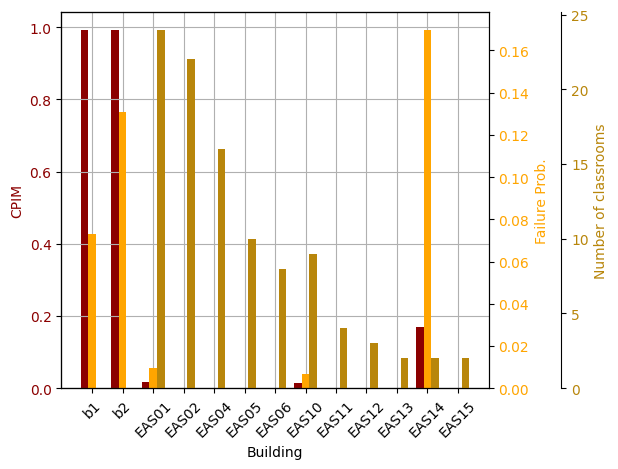

In [69]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

keys = list(cpim[sc].keys())
x = range(len(keys))
bar_width = 0.25

# First bar (left axis)
ax1.bar([i - bar_width for i in x], list(cpim[sc].values()), 
        width=bar_width, color='darkred', label='CPIM')
ax1.set_ylabel('CPIM', color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')
ax1.set_xticks(x)
ax1.set_xticklabels(keys, rotation=45)
ax1.set_xlabel('Building')
ax1.grid()

# Second bar (right axis)
ax2 = ax1.twinx()
ax2.bar(x, [pr[0] for pr in probs['bridge'].values()] + [pr[0] for pr in probs[sc].values()], 
        width=bar_width, color='orange', label='Failure Prob')
ax2.set_ylabel('Failure Prob.', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Third bar (new axis, shifted right)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.17))  # move third axis further right
ax3.bar([i + bar_width for i in x], [0,0]+[varis[sc][b].values[1] for b in build_names[sc]], 
        width=bar_width, color='darkgoldenrod', label='Third Metric')
ax3.set_ylabel('Number of classrooms', color='darkgoldenrod')
ax3.tick_params(axis='y', labelcolor='darkgoldenrod')

plt.tight_layout()
plt.show()


Comparing to Exercise 02, the relative importance between school buildings becomes very different (e.g. EAS01 and EAS02 are less important than EAS14).